In [168]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
%env MLFLOW_TRACKING_URI=sqlite:///mlruns.db

env: MLFLOW_TRACKING_URI=sqlite:///mlruns.db


In [169]:
import numpy as np
import tensorflow as tf

# Set seed for numpy
np.random.seed(42)

# Set seed for TensorFlow
tf.random.set_seed(42)


In [170]:
# Load the dataset
data = pd.read_csv("../data/external/ihsg 14-12-22 till 22-04-24.csv")
# data = pd.read_csv("../data/external/5 tahun.csv")
data.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-12-14,6810.355957,6854.098145,6774.131836,6801.749023,6801.749023,215430000
1,2022-12-15,6801.789063,6801.837891,6740.955078,6751.859863,6751.859863,145093400
2,2022-12-16,6751.859863,6812.192871,6693.765137,6812.192871,6812.192871,156126900


In [171]:
lengh_data = len(data)
split_ratio = 0.8
lengh_train = round(lengh_data * split_ratio)
lengh_validation = lengh_data - lengh_train

In [172]:
data = data.drop(["Volume"], axis=1)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index("Date")

In [173]:
def time_series_to_supervised(data, n_in=1, n_out=1, dropnan=True, var_names=None):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        if var_names is None:
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        else:
            names += [(var_names[j] + '(t-%d)' % i) for j in range(n_vars)]
    
    # Output sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            if var_names is None:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [(var_names[j] + '(t)') for j in range(n_vars)]
        else:
            if var_names is None:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            else:
                names += [(var_names[j] + '(t+%d)' % i) for j in range(n_vars)]
    
    # Concatenate all columns
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

In [174]:
# Apply the function to your data
var_names = data.columns
data_supervised = time_series_to_supervised(data, n_in=15, n_out=1, var_names=var_names)


In [175]:
# Split the data into training and validation sets
train_data = data_supervised[:lengh_train]
validation_data = data_supervised[lengh_train:]

In [176]:
scaler = MinMaxScaler()

# Scale the training data
scaled_train_data = scaler.fit_transform(train_data)
scaled_train_data = pd.DataFrame(scaled_train_data, columns=train_data.columns)


In [177]:
# Separate the target and features for training
y_train_scaled = scaled_train_data[["Open(t)"]]  
X_train_scaled = scaled_train_data.drop(["Open(t)", "Close(t)", "High(t)", "Low(t)", "Adj Close(t)"], axis=1)


In [178]:
# Reshape the data for LSTM
timesteps = 15
features = 5
X_train = []
for i in range(timesteps):
    X_train.append(X_train_scaled.iloc[:, i*features:(i+1)*features].values)

X_train = np.array(X_train).transpose(1, 0, 2)

print(X_train.shape)

(255, 15, 5)


In [179]:
mlflow.set_experiment("Stock Forecasting")

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1723652088995, experiment_id='1', last_update_time=1723652370853, lifecycle_stage='active', name='Stock Forecasting', tags={}>

In [180]:
run_name = "LSTM_Model_Training"

with mlflow.start_run(run_name=run_name):
    model_lstm = Sequential()

    # Adding layers
    model_lstm.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model_lstm.add(Dropout(0.1))
    model_lstm.add(LSTM(128, activation='relu', return_sequences=False))
    model_lstm.add(Dense(128))
    model_lstm.add(Dense(1))

    # Compile the model
    model_lstm.compile(optimizer='adam', loss="mse", metrics=["mse"])

    # Summary of the model (now the model is built)
    model_lstm.summary()

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='loss', patience=20, verbose=1, restore_best_weights=True)
    mlflow.keras.autolog()
    # Fit the model with early stopping
    hist = model_lstm.fit(X_train, train_data['Open(t)'], 
                          epochs=200, 
                          batch_size=32,
                          callbacks=[early_stopping])
    
    
    y_pred = model_lstm.predict(X_train)
    y_pred.squeeze()
    t_mse = np.mean((y_pred.squeeze() - train_data['Open(t)'])**2)

    # Menghitung Root Mean Squared Error (RMSE)
    t_rmse = np.sqrt(t_mse)

    mlflow.log_metrics({"train_mse": t_mse, "train_rmse": t_rmse})
    scaled_val_data = scaler.fit_transform(validation_data)

    # Konversi data yang telah dinormalisasi kembali ke dalam DataFrame
    scaled_val_data = pd.DataFrame(scaled_val_data, columns=validation_data.columns)
    y_val_scaled = scaled_val_data[["Open(t)"]]  # Ambil kolom Open(t) sebagai target
    X_val_scaled = scaled_val_data.drop(["Open(t)", "Close(t)", "High(t)", "Low(t)", "Adj Close(t)"], axis=1)
    X_val = []
    for i in range(timesteps):
        X_val.append(X_val_scaled.iloc[:, i*features:(i+1)*features].values)

    # Ubah list menjadi array numpy
    X_val = np.array(X_val)
    X_val = X_val.transpose(1, 0, 2)
    # Bentuknya menjadi (jumlah_sampel, timestep, feature)
    y_val_pred = model_lstm.predict(X_val)
    y_val_pred.squeeze()
    mse = np.mean((y_val_pred.squeeze() - validation_data['Open(t)'])**2)

    # Menghitung Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    mlflow.log_metrics({"val_mse": mse, "val_rmse": rmse})

    mlflow.end_run()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_11 (Bidirect  (None, 15, 256)           137216    
 ional)                                                          
                                                                 
 dropout_11 (Dropout)        (None, 15, 256)           0         
                                                                 
 lstm_23 (LSTM)              (None, 128)               197120    
                                                                 
 dense_22 (Dense)            (None, 128)               16512     
                                                                 
 dense_23 (Dense)            (None, 1)                 129       
                                                                 
Total params: 350977 (1.34 MB)
Trainable params: 350977 (1.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

2024/08/14 23:26:55 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/200
6/8 [=====================>........] - ETA: 0s - loss: 47353716.0000 - mse: 47353716.0000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0476s vs `on_train_batch_end` time: 0.3087s). Check your callbacks.


8/8 [==============================] - ETA: 0s - loss: 47413008.0000 - mse: 47413008.0000

2024/08/14 23:27:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 8s 55ms/step - loss: 47413008.0000 - mse: 47413008.0000
Epoch 2/200
8/8 [==============================] - ETA: 0s - loss: 45953280.0000 - mse: 45953280.0000

2024/08/14 23:27:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 53ms/step - loss: 45953280.0000 - mse: 45953280.0000
Epoch 3/200
8/8 [==============================] - ETA: 0s - loss: 34561952.0000 - mse: 34561952.0000

2024/08/14 23:27:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 58ms/step - loss: 34561952.0000 - mse: 34561952.0000
Epoch 4/200
8/8 [==============================] - ETA: 0s - loss: 34771044.0000 - mse: 34771044.0000

2024/08/14 23:27:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 56ms/step - loss: 34771044.0000 - mse: 34771044.0000
Epoch 5/200
8/8 [==============================] - ETA: 0s - loss: 24277190.0000 - mse: 24277190.0000

2024/08/14 23:27:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 1s 71ms/step - loss: 24277190.0000 - mse: 24277190.0000
Epoch 6/200
8/8 [==============================] - ETA: 0s - loss: 10810626.0000 - mse: 10810626.0000

2024/08/14 23:27:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 56ms/step - loss: 10810626.0000 - mse: 10810626.0000
Epoch 7/200
8/8 [==============================] - ETA: 0s - loss: 4973365.0000 - mse: 4973365.0000

2024/08/14 23:27:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 1s 65ms/step - loss: 4973365.0000 - mse: 4973365.0000
Epoch 8/200
7/8 [=========================>....] - ETA: 0s - loss: 1999320.7500 - mse: 1999320.7500

2024/08/14 23:27:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 50ms/step - loss: 1954315.2500 - mse: 1954315.2500
Epoch 9/200
8/8 [==============================] - ETA: 0s - loss: 883525.3750 - mse: 883525.3750 

2024/08/14 23:27:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 50ms/step - loss: 883525.3750 - mse: 883525.3750
Epoch 10/200
7/8 [=========================>....] - ETA: 0s - loss: 387881.8438 - mse: 387881.8438

2024/08/14 23:27:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 56ms/step - loss: 375862.7812 - mse: 375862.7812
Epoch 11/200
7/8 [=========================>....] - ETA: 0s - loss: 241193.2031 - mse: 241193.2031

2024/08/14 23:27:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 47ms/step - loss: 233225.1094 - mse: 233225.1094
Epoch 12/200
8/8 [==============================] - ETA: 0s - loss: 149436.9688 - mse: 149436.9688

2024/08/14 23:27:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 47ms/step - loss: 149436.9688 - mse: 149436.9688
Epoch 13/200
8/8 [==============================] - ETA: 0s - loss: 106470.6016 - mse: 106470.6016

2024/08/14 23:27:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 56ms/step - loss: 106470.6016 - mse: 106470.6016
Epoch 14/200
7/8 [=========================>....] - ETA: 0s - loss: 109481.5469 - mse: 109481.5469

2024/08/14 23:27:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 48ms/step - loss: 105150.2109 - mse: 105150.2109
Epoch 15/200
7/8 [=========================>....] - ETA: 0s - loss: 85547.2031 - mse: 85547.2031

2024/08/14 23:27:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 46ms/step - loss: 91798.6250 - mse: 91798.6250
Epoch 16/200
7/8 [=========================>....] - ETA: 0s - loss: 67912.3672 - mse: 67912.3672

2024/08/14 23:27:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 53ms/step - loss: 64677.8555 - mse: 64677.8555
Epoch 17/200
7/8 [=========================>....] - ETA: 0s - loss: 58112.6016 - mse: 58112.6016

2024/08/14 23:27:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 45ms/step - loss: 58207.1289 - mse: 58207.1289
Epoch 18/200
8/8 [==============================] - ETA: 0s - loss: 50943.5938 - mse: 50943.5938

2024/08/14 23:27:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 47ms/step - loss: 50943.5938 - mse: 50943.5938
Epoch 19/200
8/8 [==============================] - ETA: 0s - loss: 54404.8477 - mse: 54404.8477

2024/08/14 23:27:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 59ms/step - loss: 54404.8477 - mse: 54404.8477
Epoch 20/200
7/8 [=========================>....] - ETA: 0s - loss: 47256.5430 - mse: 47256.5430

2024/08/14 23:27:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 46ms/step - loss: 45113.7266 - mse: 45113.7266
Epoch 21/200
7/8 [=========================>....] - ETA: 0s - loss: 33639.9297 - mse: 33639.9297

2024/08/14 23:27:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 47ms/step - loss: 32714.0898 - mse: 32714.0898
Epoch 22/200
8/8 [==============================] - ETA: 0s - loss: 27523.7422 - mse: 27523.7422

2024/08/14 23:27:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 54ms/step - loss: 27523.7422 - mse: 27523.7422
Epoch 23/200
7/8 [=========================>....] - ETA: 0s - loss: 24283.7949 - mse: 24283.7949

2024/08/14 23:27:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 45ms/step - loss: 24108.2812 - mse: 24108.2812
Epoch 24/200
7/8 [=========================>....] - ETA: 0s - loss: 28533.7129 - mse: 28533.7129

2024/08/14 23:27:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 45ms/step - loss: 27756.2598 - mse: 27756.2598
Epoch 25/200
7/8 [=========================>....] - ETA: 0s - loss: 22765.6699 - mse: 22765.6699

2024/08/14 23:27:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 53ms/step - loss: 23137.7246 - mse: 23137.7246
Epoch 26/200
7/8 [=========================>....] - ETA: 0s - loss: 31883.7461 - mse: 31883.7461

2024/08/14 23:27:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 46ms/step - loss: 32751.2305 - mse: 32751.2305
Epoch 27/200
7/8 [=========================>....] - ETA: 0s - loss: 28924.3867 - mse: 28924.3867

2024/08/14 23:27:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 48ms/step - loss: 29553.6738 - mse: 29553.6738
Epoch 28/200
7/8 [=========================>....] - ETA: 0s - loss: 35729.6953 - mse: 35729.6953

2024/08/14 23:27:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 55ms/step - loss: 33530.4570 - mse: 33530.4570
Epoch 29/200
8/8 [==============================] - ETA: 0s - loss: 21490.1680 - mse: 21490.1680

2024/08/14 23:27:15 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 52ms/step - loss: 21490.1680 - mse: 21490.1680
Epoch 30/200
8/8 [==============================] - ETA: 0s - loss: 20348.2480 - mse: 20348.2480

2024/08/14 23:27:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 49ms/step - loss: 20348.2480 - mse: 20348.2480
Epoch 31/200
8/8 [==============================] - ETA: 0s - loss: 15769.3428 - mse: 15769.3428

2024/08/14 23:27:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 1s 60ms/step - loss: 15769.3428 - mse: 15769.3428
Epoch 32/200
8/8 [==============================] - ETA: 0s - loss: 15821.3164 - mse: 15821.3164

2024/08/14 23:27:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 48ms/step - loss: 15821.3164 - mse: 15821.3164
Epoch 33/200
8/8 [==============================] - ETA: 0s - loss: 17735.5098 - mse: 17735.5098

2024/08/14 23:27:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 48ms/step - loss: 17735.5098 - mse: 17735.5098
Epoch 34/200
7/8 [=========================>....] - ETA: 0s - loss: 17824.4355 - mse: 17824.4355

2024/08/14 23:27:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 49ms/step - loss: 16402.9219 - mse: 16402.9219
Epoch 35/200
8/8 [==============================] - ETA: 0s - loss: 14337.4375 - mse: 14337.4375

2024/08/14 23:27:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 47ms/step - loss: 14337.4375 - mse: 14337.4375
Epoch 36/200
8/8 [==============================] - ETA: 0s - loss: 17017.7773 - mse: 17017.7773

2024/08/14 23:27:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 47ms/step - loss: 17017.7773 - mse: 17017.7773
Epoch 37/200
8/8 [==============================] - ETA: 0s - loss: 29554.9805 - mse: 29554.9805

2024/08/14 23:27:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 57ms/step - loss: 29554.9805 - mse: 29554.9805
Epoch 38/200
8/8 [==============================] - ETA: 0s - loss: 22422.2227 - mse: 22422.2227

2024/08/14 23:27:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 47ms/step - loss: 22422.2227 - mse: 22422.2227
Epoch 39/200
8/8 [==============================] - ETA: 0s - loss: 18677.3809 - mse: 18677.3809

2024/08/14 23:27:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 47ms/step - loss: 18677.3809 - mse: 18677.3809
Epoch 40/200
8/8 [==============================] - ETA: 0s - loss: 12242.9834 - mse: 12242.9834

2024/08/14 23:27:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 55ms/step - loss: 12242.9834 - mse: 12242.9834
Epoch 41/200
8/8 [==============================] - ETA: 0s - loss: 16376.8369 - mse: 16376.8369

2024/08/14 23:27:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 52ms/step - loss: 16376.8369 - mse: 16376.8369
Epoch 42/200
8/8 [==============================] - ETA: 0s - loss: 14847.7246 - mse: 14847.7246

2024/08/14 23:27:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 53ms/step - loss: 14847.7246 - mse: 14847.7246
Epoch 43/200
8/8 [==============================] - ETA: 0s - loss: 15099.5342 - mse: 15099.5342

2024/08/14 23:27:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 1s 62ms/step - loss: 15099.5342 - mse: 15099.5342
Epoch 44/200
7/8 [=========================>....] - ETA: 0s - loss: 20389.8730 - mse: 20389.8730

2024/08/14 23:27:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 54ms/step - loss: 19854.7520 - mse: 19854.7520
Epoch 45/200
8/8 [==============================] - ETA: 0s - loss: 23327.9805 - mse: 23327.9805

2024/08/14 23:27:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 57ms/step - loss: 23327.9805 - mse: 23327.9805
Epoch 46/200
8/8 [==============================] - ETA: 0s - loss: 29243.0625 - mse: 29243.0625

2024/08/14 23:27:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 53ms/step - loss: 29243.0625 - mse: 29243.0625
Epoch 47/200
7/8 [=========================>....] - ETA: 0s - loss: 20643.1035 - mse: 20643.1035

2024/08/14 23:27:23 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 51ms/step - loss: 21336.9824 - mse: 21336.9824
Epoch 48/200
8/8 [==============================] - ETA: 0s - loss: 15917.5312 - mse: 15917.5312

2024/08/14 23:27:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 1s 69ms/step - loss: 15917.5312 - mse: 15917.5312
Epoch 49/200
8/8 [==============================] - ETA: 0s - loss: 19370.5879 - mse: 19370.5879

2024/08/14 23:27:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 51ms/step - loss: 19370.5879 - mse: 19370.5879
Epoch 50/200
8/8 [==============================] - ETA: 0s - loss: 15299.1768 - mse: 15299.1768

2024/08/14 23:27:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 54ms/step - loss: 15299.1768 - mse: 15299.1768
Epoch 51/200
8/8 [==============================] - ETA: 0s - loss: 17462.8809 - mse: 17462.8809

2024/08/14 23:27:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 1s 60ms/step - loss: 17462.8809 - mse: 17462.8809
Epoch 52/200
8/8 [==============================] - ETA: 0s - loss: 18477.9102 - mse: 18477.9102

2024/08/14 23:27:25 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 51ms/step - loss: 18477.9102 - mse: 18477.9102
Epoch 53/200
8/8 [==============================] - ETA: 0s - loss: 23789.4766 - mse: 23789.4766

2024/08/14 23:27:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 1s 67ms/step - loss: 23789.4766 - mse: 23789.4766
Epoch 54/200
8/8 [==============================] - ETA: 0s - loss: 30951.2832 - mse: 30951.2832

2024/08/14 23:27:26 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 61ms/step - loss: 30951.2832 - mse: 30951.2832
Epoch 55/200
8/8 [==============================] - ETA: 0s - loss: 30507.1836 - mse: 30507.1836

2024/08/14 23:27:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 51ms/step - loss: 30507.1836 - mse: 30507.1836
Epoch 56/200
8/8 [==============================] - ETA: 0s - loss: 28728.6699 - mse: 28728.6699

2024/08/14 23:27:27 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 49ms/step - loss: 28728.6699 - mse: 28728.6699
Epoch 57/200
7/8 [=========================>....] - ETA: 0s - loss: 27500.7051 - mse: 27500.7051

2024/08/14 23:27:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 55ms/step - loss: 25668.5547 - mse: 25668.5547
Epoch 58/200
8/8 [==============================] - ETA: 0s - loss: 20155.0430 - mse: 20155.0430

2024/08/14 23:27:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 49ms/step - loss: 20155.0430 - mse: 20155.0430
Epoch 59/200
8/8 [==============================] - ETA: 0s - loss: 15386.7822 - mse: 15386.7822

2024/08/14 23:27:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 0s 52ms/step - loss: 15386.7822 - mse: 15386.7822
Epoch 60/200
8/8 [==============================] - ETA: 0s - loss: 12321.5049 - mse: 12321.5049Restoring model weights from the end of the best epoch: 40.


2024/08/14 23:27:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


8/8 [==============================] - 1s 67ms/step - loss: 12321.5049 - mse: 12321.5049
Epoch 60: early stopping
1/1 [==============================] - 1s 723ms/step
INFO:tensorflow:Assets written to: C:\Users\ZADO\AppData\Local\Temp\tmprvd5djki\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\ZADO\AppData\Local\Temp\tmprvd5djki\model\data\model\assets


2/2 [==============================] - 0s 7ms/step


2024/08/14 23:28:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run LSTM_Model_Training at: http://127.0.0.1:5000/#/experiments/1/runs/4b6dc6f5faee449aa61e2c1e6c815e1c.
2024/08/14 23:28:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [181]:


print("MSE:", t_mse)
print("RMSE:", t_rmse)

MSE: 5712.589136365383
RMSE: 75.58167196063728


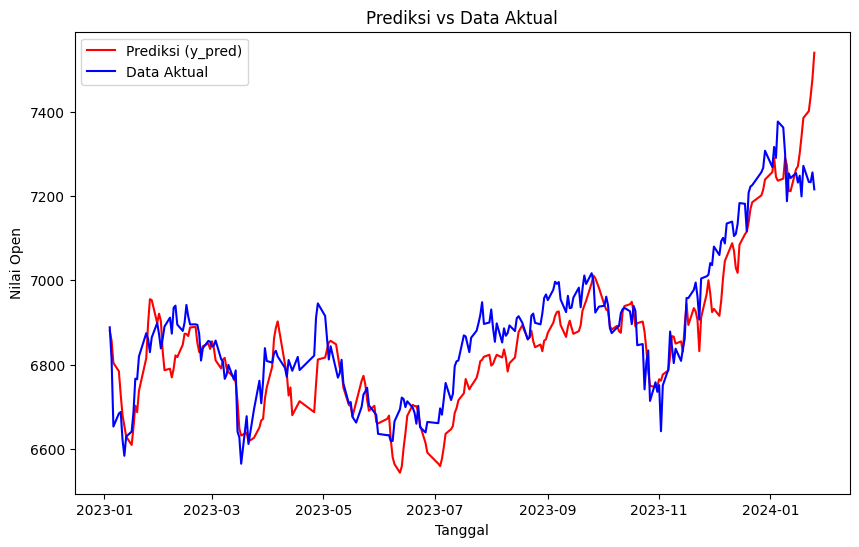

In [182]:

plt.figure(figsize=(10, 6))
plt.plot(train_data.index, y_pred.squeeze(), label='Prediksi (y_pred)', color='red')
plt.plot(train_data.index, train_data['Open(t)'], label='Data Aktual', color='blue')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Open')
plt.title('Prediksi vs Data Aktual')
plt.legend()
plt.show()


In [183]:

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 168012.21073914578
RMSE: 409.892925944259


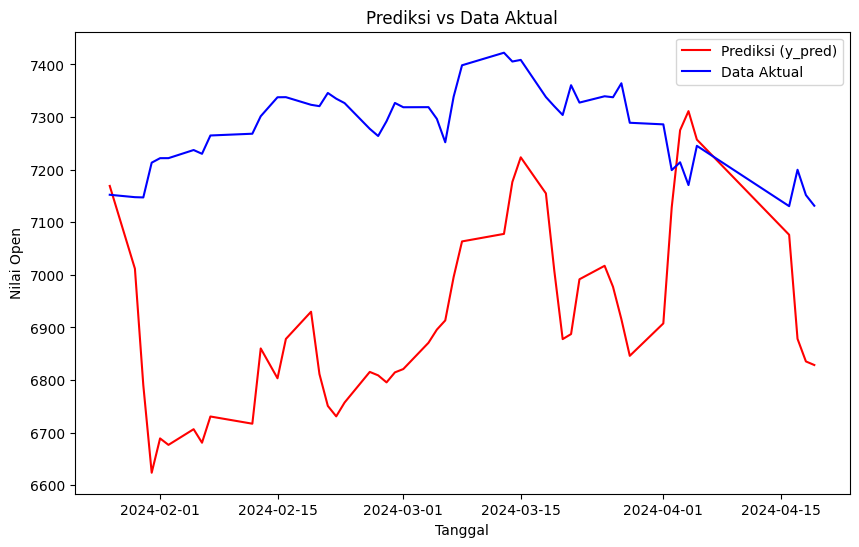

In [184]:
import matplotlib.pyplot as plt

# Plot hasil prediksi (y_pred) dan data aktual (train_data['Open(t)'])
plt.figure(figsize=(10, 6))
plt.plot(validation_data.index, y_val_pred.squeeze(), label='Prediksi (y_pred)', color='red')
plt.plot(validation_data.index, validation_data['Open(t)'], label='Data Aktual', color='blue')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Open')
plt.title('Prediksi vs Data Aktual')
plt.legend()
plt.show()
